# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Árboles de Decisión</center>
### <center> Práctica Búsqueda de Hiperparámetros </center>

## Objetivo

En esta notebook el objetivo es clasificar vinos segun su calidad (bueno /malo) utilizando árboles de decisón.

Para esto vamos a construir el "mejor" clasificador eligiendo los hiperparametros más adecuados mediante validación cruzada.

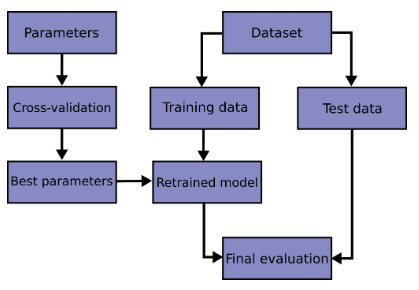

¿ A qué nos referimos con mejor?

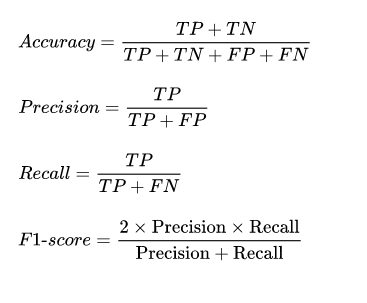

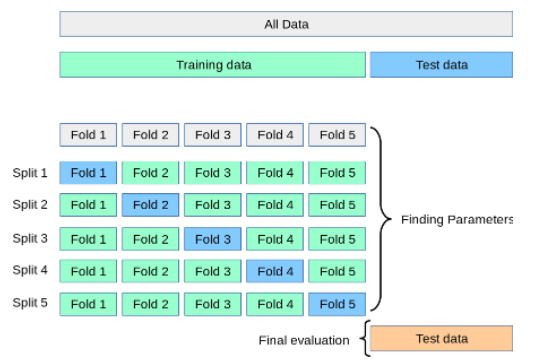

Links de interés: https://scikit-learn.org/stable/modules/cross_validation.html

## Carga de Datos y librerías

In [ ]:
import pandas as pd
import numpy as np

import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('always')


El archivo que usamos se llama "wine.csv" y se encuentra subido en el drive de la materia:<br>
Material Alumnos -> Clases Prácticas ->Datasets

In [ ]:
dataset=pd.read_csv('https://drive.google.com/uc?export=download&id=1R5tKSxwPn5CS5_p2Un4e6hlEb9JZQMZy')

## Exploración de los datos


Este conjunto de datos contiene la información relacionada con el vino tinto, varios factores que afectan la calidad. 

Fuente de este conjunto de datos: https://archive.ics.uci.edu/ml/datasets/wine+quality

Información de atributos(basadas en pruebas fisicoquímicas):

* acidez fija
* acidez volátil
* ácido cítrico
* azúcar residual
* cloruros
* dióxido de azufre libre
* dióxido de azufre total
* densidad
* pH
* sulfatos
* alcohol

Variable de "target" (basada en datos sensoriales):
calidad ('buena' y 'mala' según la puntuación >5 y <5)

In [ ]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


In [ ]:
dataset['quality'] = dataset['quality'].map({'bad':1,'good':0},na_action=None)

In [ ]:
dataset.shape

(1599, 12)

In [ ]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

TODO : Análisis de correlación entre features

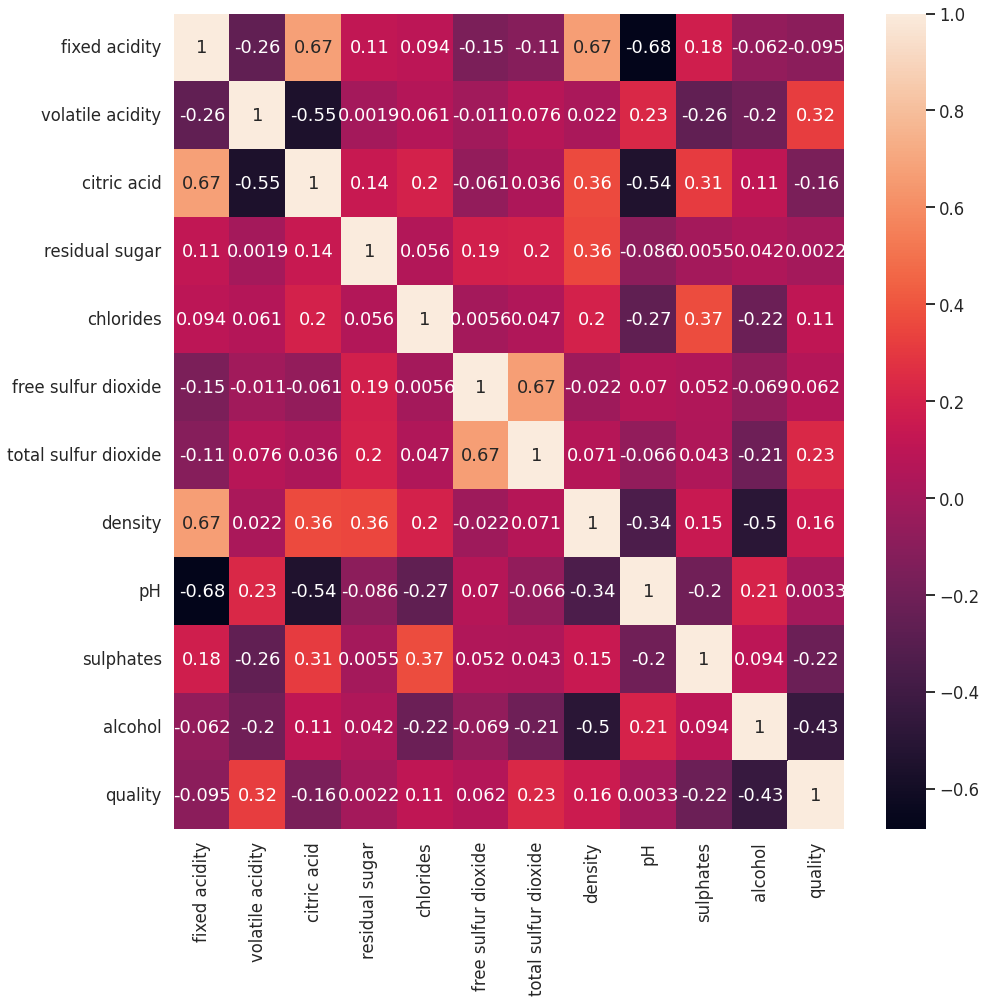

In [ ]:
matriz_correlacion=dataset.corr()

plt.figure(figsize=(15,15))
sns.heatmap(matriz_correlacion, annot = True)
plt.show()

## Crear Set de Entrenamiento y Set de Test

Vamos a crear un conjunto de entrenamiento con el 80% de los datos y otro conjunto de test con el 20%.

Intentaremos respetar la proporcion de nuestro "target" en ambos conjuntos.

In [ ]:
features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
          'pH', 'sulphates', 'alcohol']
          
target='quality'

In [ ]:
#Verifico balanceo de clases
dataset[target].value_counts(normalize=True)*100

0    53.470919
1    46.529081
Name: quality, dtype: float64

Los árboles de decisión no suelen estar muy afectados por clases desbalanceadas pero sí es importante tenerlo en cuenta para otros algoritmos de clasificación.

In [ ]:
#Separo un set de Evaluacion
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset[features].values, 
                                                    dataset[target].values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=dataset[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 1279
# Datos Prueba: 320
% Positivos Entrenamiento: 46.521
% Positivos Prueba: 46.562


## Randomized Search Cross Validation

¿Cómo buscar la mejor combinación de hiperparámetros?

Exploramos un espacio de búsqueda, usando k-fold CV para medir el desempeño de cada combinación.
Al terminar, nos quedamos con la combinación con
mejor desempeño y entrenamos un único modelo usando todos los datos de train.

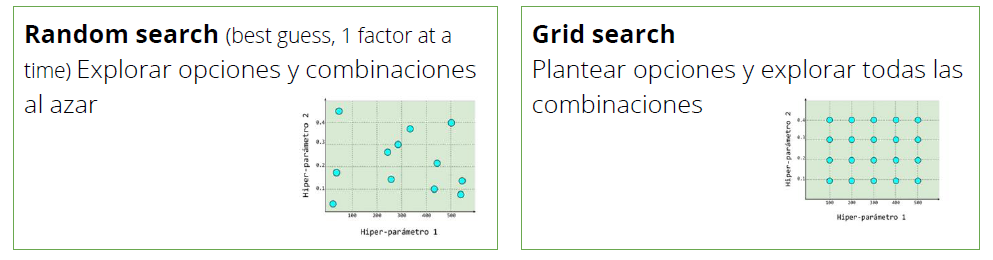

Algunos hiperparámetros de los árboles de decisión
* Criterio de elección de atributos en cada nodo (Information Gain, Gini Gain)
* Criterio de parada (ej: máxima profundidad)
* Estrategia de poda

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero porbar
n=10 

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,6))}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.016666666666666666}
0.7053653839994465


In [ ]:
randomcv.cv_results_['mean_test_score']

array([0.68273825, 0.69267092, 0.70536538, 0.68273825, 0.68273825,
       0.68273825, 0.68273825, 0.68273825, 0.68273825, 0.68273825])

In [ ]:
#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))


sulphates: 0.2631646151150383
alcohol: 0.7368353848849617


TODO: Probar GridSearch Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
#n=

#Conjunto de parámetros que quiero usar
#params_grid = {}
                
#Cantidad de splits para el Cross Validation
#folds=

#Kfold estratificado
#kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
#base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
#scorer_fn = make_scorer(sk.metrics.f1_score)

#GridSearch CV
#gridcv = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

#gridcv.fit(x_train,y_train)

#gridcv.cv_results_ 
#etc....

## Predicción y Evaluación del Modelo con mejores hiperparámetros

In [ ]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(features))
print(reglas)

|--- alcohol <= 10.55
|   |--- sulphates <= 0.53
|   |   |--- class: 1
|   |--- sulphates >  0.53
|   |   |--- alcohol <= 9.85
|   |   |   |--- class: 1
|   |   |--- alcohol >  9.85
|   |   |   |--- class: 0
|--- alcohol >  10.55
|   |--- sulphates <= 0.58
|   |   |--- alcohol <= 11.45
|   |   |   |--- class: 1
|   |   |--- alcohol >  11.45
|   |   |   |--- class: 0
|   |--- sulphates >  0.58
|   |   |--- class: 0



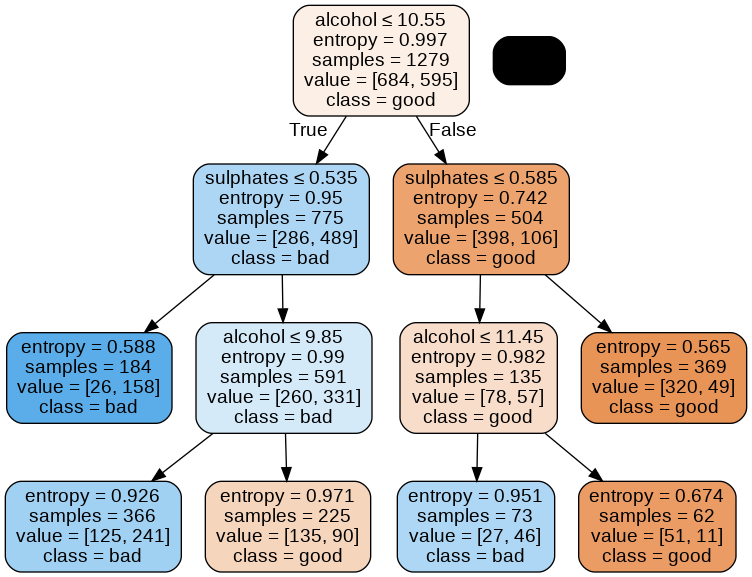

In [ ]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['good','bad'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

TODO: guardar el modelo entrenado en un archivo <br>
https://scikit-learn.org/stable/model_persistence.html


F1-Score: 0.7070063694267515


Text(19.5, 0.5, 'True')

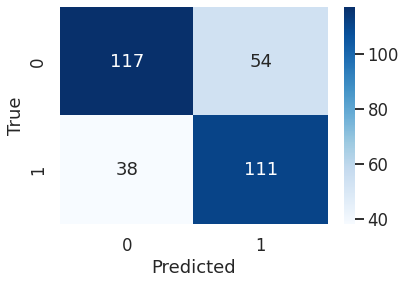

In [ ]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
arbol.predict_proba(x_test)[0:10]

array([[0.34153005, 0.65846995],
       [0.94146341, 0.05853659],
       [0.34153005, 0.65846995],
       [0.6       , 0.4       ],
       [0.34153005, 0.65846995],
       [0.34153005, 0.65846995],
       [0.77439024, 0.22560976],
       [0.34153005, 0.65846995],
       [0.11931818, 0.88068182],
       [0.94146341, 0.05853659]])

## Entrenamiento Cross Validation

Veamos qué pasa con las métricas si entrenamos el mismo árbol con diferentes conjuntos de datos (en este caso con cada split de un CV)

In [ ]:
#Entrenamiento con 10 Fold Cross Validation 
from sklearn.model_selection import cross_validate, StratifiedKFold

# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=10) 
 
#Creo árbol con los mejores hiperparámetros 
arbolcv=DecisionTreeClassifier()#.set_params(**randomcv.best_params_)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Hago CV
resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

#Selecciono el arbol con mejor performance
metricsCV=resultados['test_score']
mejor_performance=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]


In [ ]:
#Métricas de cada split
metricsCV

array([0.71666667, 0.73504274, 0.74576271, 0.68421053, 0.64220183,
       0.68907563, 0.70967742, 0.75409836, 0.70689655, 0.77586207])

In [ ]:
#metricsCV==max(metricsCV)
#np.where(metricsCV==max(metricsCV))[0][0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


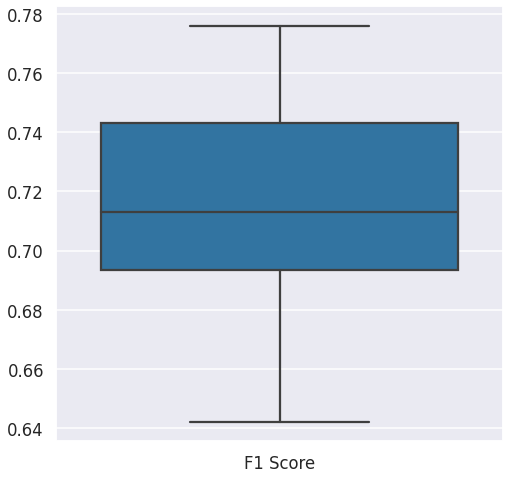

In [ ]:
#Grafico Boxplot -Entrenado con 10 Fold Cross Validation

metric_labelsCV = ['F1 Score']*len(metricsCV) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metric_labelsCV,metricsCV)

In [ ]:
#Importancia y reglas del Árbol con mejor Performance
from sklearn.tree import export_text

feat_imps = mejor_performance.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))
print()

reglas = export_text(mejor_performance, feature_names=list(features))
print(reglas)

residual sugar: 0.03572535807618265
free sulfur dioxide: 0.038990039495963275
pH: 0.04791148057599052
density: 0.05030152856032733
citric acid: 0.050847443839466
chlorides: 0.08037458256696087
sulphates: 0.09627014406172052
fixed acidity: 0.10146544182232849
total sulfur dioxide: 0.10493126120432236
volatile acidity: 0.11735772591450791
alcohol: 0.27582499388223014

|--- alcohol <= 10.55
|   |--- sulphates <= 0.53
|   |   |--- volatile acidity <= 0.34
|   |   |   |--- sulphates <= 0.46
|   |   |   |   |--- class: 1
|   |   |   |--- sulphates >  0.46
|   |   |   |   |--- class: 0
|   |   |--- volatile acidity >  0.34
|   |   |   |--- alcohol <= 9.65
|   |   |   |   |--- residual sugar <= 9.00
|   |   |   |   |   |--- volatile acidity <= 0.56
|   |   |   |   |   |   |--- pH <= 3.24
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- pH >  3.24
|   |   |   |   |   |   |   |--- pH <= 3.31
|   |   |   |   |   |   |   |   |--- residual sugar <= 2.85
|   |   |   |   |   |  

In [ ]:
#Grafico
dot_data = StringIO()
export_graphviz(mejor_performance, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['good','bad'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

## Predicción y Evaluación del Modelo

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       171
           1       0.71      0.71      0.71       149

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



Text(19.5, 0.5, 'True')

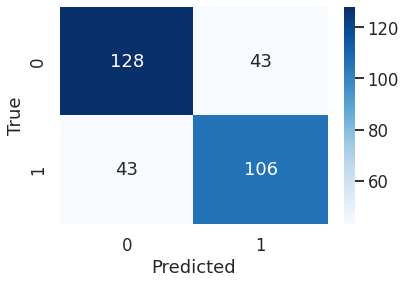

In [ ]:
#Arbol CV set de evaluación

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

#Predicción sobre el set de evaluacion
y_pred= mejor_performance.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')